# MODELISATION

To address our problem statement, we implement 3 machine learning models: Random Forest, XGBoost, and CatBoost.

We use machine learning models to predict the genre of a song based on the available variables. We first use a Random Forest model, followed by an XGBoost model, and finally a Cat Boost model. We end with a conclusion to then compare the three.

### Import

We use version 1.5.2 of scikit-learn because the version 1.6 modified the API related to its "tags," which caused errors when we attempted to train XGBoost.

In [44]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# Preprocessing
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

# Model Selection and Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve

# Algorithms
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    f1_score,
    zero_one_loss,
    classification_report,
)


We will work on the dataframe generated during the feature engineering phase, which we decided to store on S3 (Datalab storage) so that it is easily accessible to us.

In [ ]:
file_path = "/tlaflotte/genre_detector/data_tracks_cleaned.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

# I - Random Forest

First, we separate the target variable (the genre) from the other variables (the features). Next, we split these sets into two parts: one for training the model and the other for testing it. Since our dataset is organized by genre, we specify that it should be randomly split using the argument `shuffle=True`.  

We could remove some variables, as our visualization step highlighted strong correlations between certain ones. This would save computation time at the cost of a slight reduction in precision. However, we chose to keep all variables because the computation time is not very long.

In [45]:
features = df.copy()

# isolation of the feature to predict
genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre', 'playlist_subgenre_encoded'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# separation in training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

# reshaping
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)

Training Features Shape: (24624, 13)
Training Genres Shape: (24624,)
Testing Features Shape: (8209, 13)
Testing Genres Shape: (8209,)


## Hyperparameter Tuning

To optimize the performance of our models, we perform hyperparameter tuning. This step aims to find the best combination of parameters that maximize the model's accuracy on the test set.

In [46]:
rf = RandomForestClassifier(random_state = 0)

print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


There are indeed too many hyperparameters to tune. To keep things manageable, we focus on the following three key hyperparameters:  

1. **Number of trees** (*n_estimators*): Controls the number of trees in the ensemble.  
2. **Maximum tree depth** (*max_depth*): Determines the maximum depth of each tree.  
3. **Minimum samples per node** (*min_child_samples* or *min_samples_split*): Specifies the minimum number of samples required in a node to allow further splitting.  

We did not specify weights for each genre since the dataset is relatively balanced. However, to further improve the model, we could assign weights to each genre to simulate a *perfectly* balanced dataset.  

Below are the values we will test to evaluate the model's performance:  

- **Number of trees (n_estimators)**: [1000, 2000, 4000]
- **Maximum depth (max_depth)**: [20,None]
- **Minimum samples per node (min_child_samples)**: [2, 4]

This selection strikes a balance between simplicity and the ability to find optimal parameters.

In [47]:
n_estimators = [1000, 2000, 4000]
max_depth = [20,None]
min_samples_split = [2, 4]

# creation of the grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
              }

print(random_grid)

{'n_estimators': [1000, 2000, 4000], 'max_depth': [20, None], 'min_samples_split': [2, 4]}


We perform a random search using these hyperparameters and rank the different combinations based on their accuracy.

In [48]:
# creation of the model
rf = RandomForestClassifier(random_state = 0, max_features = 'sqrt', bootstrap = True)

# random search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 12, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# fit
rf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(rf_random.cv_results_["params"]),pd.DataFrame(rf_random.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(rf_random.best_params_)
print(pd_res.head)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  49.1s
[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  49.2s
[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  51.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.7min
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.7min
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.6min


/opt/conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  46.9s
[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  45.5s
[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  49.7s
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.2min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.2min
[CV] END max_depth=20, min_samples_split=4, n_estimators=2000; total time= 1.5min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.2min
[CV] END max_depth=20, min_samples_split=4, n_estimators=2000; total time= 1.7min
[CV] END max_depth=20, min_samples_split=4, n_estimators=2000; total time= 1.6min
[CV] END max_depth=None, min_samples_split=2, n_estimators=1000; total time=  49.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=1000; total time=  58.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=1000; total time=  53.0s
[CV] END m

After these initial results, we deduce that the best performance is achieved when `min_samples_split` is set to 2. It also appears that 4000 trees and a maximum depth of 20 yield the best results.  

With `min_samples_split` fixed at 2, we aim to validate this hypothesis by continuing our hyperparameter selection (number of trees and maximum tree depth) using a grid search.  

As before, we rank the results based on accuracy.

In [49]:
param_grid = {
    'max_depth': [20, None],
    'min_samples_split': [2],
    'n_estimators': [2000, 4000]
}
print(param_grid)

# création du modèle
rf = RandomForestClassifier(random_state = 0, bootstrap=True)

# grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)

{'max_depth': [20, None], 'min_samples_split': [2], 'n_estimators': [2000, 4000]}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.6min
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.8min
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time= 1.8min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.5min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.5min
[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time= 1.9min
[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time= 1.9min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 3.5min
[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time= 1.7min
[CV] END max_depth=None, min_samples_split=2, n_estimators=4000; total time= 3.1min
[CV] END max_depth=None, min_s

Based on the outcomes, we finalize the number of trees at 4000 and retain a maximum depth of 20. Setting the depth too high may lead to overfitting, so we mitigate this risk by opting for a more controlled depth.

This concludes the hyperparameter tuning section, and we can now proceed to run the model.

## Running the model

We can now run the model.

In [50]:
# creation of the model
rf = RandomForestClassifier(n_estimators=4000, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, criterion='gini' ,random_state=0)

# fit
rf.fit(train_features, train_genres)

# prédictions
predictions = rf.predict(test_features)

# Zero_one_loss error
errors = zero_one_loss(test_genres, predictions, normalize=True)
print('zero_one_loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('accuracy_score on test dataset :', accuracy_test)

print(classification_report(predictions, test_genres))

zero_one_loss error normalized: 0.4313558289682057
accuracy_score on test dataset : 0.5686441710317943
              precision    recall  f1-score   support

         edm       0.70      0.68      0.69      1572
       latin       0.40      0.52      0.45      1006
         pop       0.36      0.38      0.37      1284
         r&b       0.48      0.50      0.49      1304
         rap       0.67      0.59      0.63      1620
        rock       0.78      0.69      0.73      1423

    accuracy                           0.57      8209
   macro avg       0.57      0.56      0.56      8209
weighted avg       0.58      0.57      0.57      8209



We achieve an accuracy of 56.8%, which is fairly good.

However, we will plot the confusion matrix to visualize the different errors.

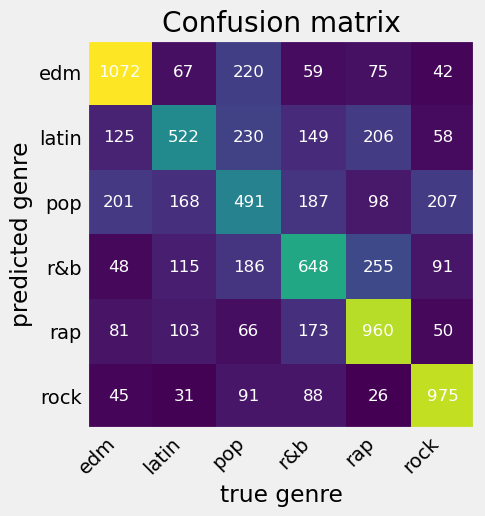

In [51]:
#Confusion matrix

mat = confusion_matrix(test_genres, predictions)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Thanks to the confusion matrix, we can see, for example, that rock music is well classified, with only a few being incorrectly predicted as pop music.

We can also observe that the model predicts genres such as EDM, rap, and rock quite well, while it struggles more with genres like Latin, pop, and R&B.

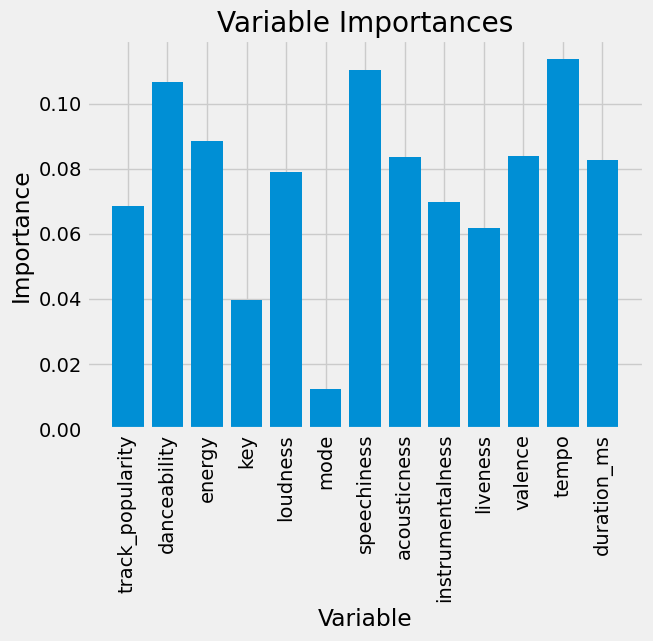

In [52]:
#Feature importances
plt.style.use('fivethirtyeight')

importances = list(rf.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

Finally, we plot the importance of each feature. We observe that `key` and `mode` are not very useful for prediction. This is expected since these are features that vary relatively little and are decoupled from each genre.

Thus, our Random Forest model achieves an accuracy of 56.8%, which is satisfactory. However, it performs poorly in identifying the latin, pop, and r&b genres, which are very common in the music world, while it does well in identifying the edm genre, which is not the most listened-to genre today.

# II - XGBoost

We will try using another model, XGBoost, to improve our previous performance.

## Genre Encoding

Since the XGBoost model only accepts numerical variables (int or float), we need to encode the categorical variable `playlist_genre`.

We assign a numerical value (between 0 and 5) to each genre in order to use this model.

In [53]:
features = df.copy()

def genre_to_num(genre):
    if genre == 'edm':
        return 0
    if genre == 'latin':
        return 1
    if genre == 'pop':
        return 2
    if genre == 'r&b':
        return 3
    if genre == 'rap':
        return 4
    if genre == 'rock':
        return 5

features['playlist_genre'] = features['playlist_genre'].apply(genre_to_num)

We can now separate the genre from the features and split these sets into training and testing parts, just as we did for the Random Forest model.

In [54]:
# isolation of the feature to predict
genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre', 'playlist_subgenre_encoded'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# separation in training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

Training Features Shape: (24624, 13)
Training Genres Shape: (24624,)
Testing Features Shape: (8209, 13)
Testing Genres Shape: (8209,)


## Hyperparameter Tuning

As the hyperparameters vary from one model to another, we will begin the hyperparameter tuning phase by examining which parameters we can adjust.

In [55]:
clf = XGBClassifier(objective= 'multi:softprob', random_state = 42)
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'multi:softprob',
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


Once again, there are numerous hyperparameters to choose from. We will focus on just two: max_depth (the maximum depth of a tree) and n_estimators (the number of trees). Here are the values for which we will test the model's accuracy.

In [56]:
random_grid = {
    "gamma" : [0],
    "learning_rate" : [0.1],
    "max_depth" : [20, None],
    "n_estimators" : [100, 200, 300, 400, 500], 
    "subsample" : [0.8]}

pprint(random_grid)

{'gamma': [0],
 'learning_rate': [0.1],
 'max_depth': [20, None],
 'n_estimators': [100, 200, 300, 400, 500],
 'subsample': [0.8]}


We will perform a random search with these different values and display the accuracy obtained for each possible combination.

In [57]:
# Model creation
clf = XGBClassifier(objective='multi:softprob', random_state=42)

# Random search
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=10, cv=3, verbose=2, random_state=0, n_jobs=-1)

# Fit the model
clf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(clf_random.cv_results_["params"]), pd.DataFrame(clf_random.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=100, subsample=0.8; total time=  17.6s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=100, subsample=0.8; total time=  18.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=100, subsample=0.8; total time=  20.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=200, subsample=0.8; total time=  27.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=200, subsample=0.8; total time=  29.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=200, subsample=0.8; total time=  26.0s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=300, subsample=0.8; total time=  33.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=300, subsample=0.8; total time=  32.6s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=300, subsample=0.8; total time=  33.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=400, subs

We choose to set `max_depth` to 20 to avoid overfitting, but this seems to result in slightly lower accuracy. To properly select the number of trees, we will perform a grid search. Here are the values we will use for this grid search.

In [58]:
param_grid = {
    "learning_rate" : [0.1], #d0.3
    "max_depth"        : [20], #d6
    "n_estimators" : [100, 200, 300], #d100
    "subsample" : [0.8], #d1
}

pprint(param_grid)

{'learning_rate': [0.1],
 'max_depth': [20],
 'n_estimators': [100, 200, 300],
 'subsample': [0.8]}


We then proceed with the grid search.

In [59]:
clf = XGBClassifier(objective= 'multi:softprob', random_state = 0)

grid = GridSearchCV(clf, param_grid = param_grid, n_jobs=-1, scoring="accuracy", cv=3) #scoring="neg_log_loss"
grid.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)

   learning_rate  max_depth  n_estimators  subsample  Accuracy
1            0.1         20           200        0.8  0.552713
2            0.1         20           300        0.8  0.552713
0            0.1         20           100        0.8  0.549870


Based on the results, we decide to keep the value of 300 trees for our final model.

## Running the model

We then run our final model with the tuned hyperparameters.

In [60]:
# model
model_xgb = XGBClassifier(objective='multi:softprob', colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=20, min_child_weight=1, n_estimators=300, subsample=0.8, random_state = 42)

# fit the model with the training data
model_xgb.fit(train_features, train_genres)

# predict the target on the test dataset
predict_test = model_xgb.predict(test_features)
 
# Accuracy Score on test dataset
accuracy_test = accuracy_score(test_genres, predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)
print(classification_report(predict_test, test_genres))


accuracy_score on test dataset :  0.5607260324034596
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1582
           1       0.40      0.49      0.44      1058
           2       0.35      0.37      0.36      1279
           3       0.47      0.49      0.48      1300
           4       0.66      0.59      0.63      1596
           5       0.76      0.69      0.72      1394

    accuracy                           0.56      8209
   macro avg       0.56      0.55      0.55      8209
weighted avg       0.57      0.56      0.57      8209



We achieve an accuracy of 56%, which is very close to the accuracy of the Random Forest model.

We can make the same observations as before. Additionally, the confusion matrix is very similar to the previous one.

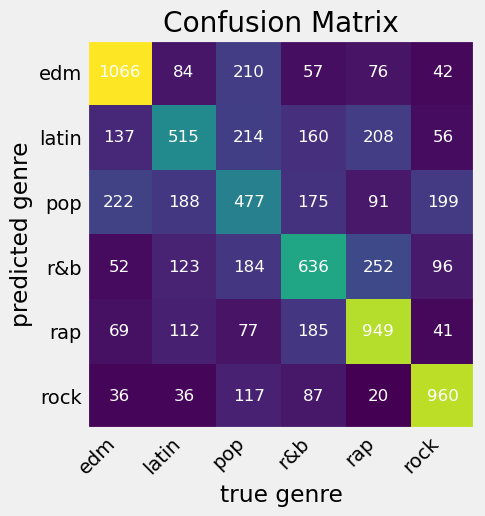

In [61]:
# Confusion matrix
mat = confusion_matrix(test_genres, predict_test)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Finally, the second model, XGBoost, gives us results very similar to the first: we can predict the genre of a song using the available Spotify data with an accuracy of 56%. We predict edm, rap, and rock well, but less accurately for latin, pop, and r&b.

# III - CatBoost

And las but not least, we will try using one last model, hoping to perform better than the previous two.

We begin, as usual, by separating the genre from the features and splitting these sets into training and testing parts.

In [62]:
# Copy features
features = df.copy()

# Isolate the target variable
genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre', 'playlist_subgenre_encoded'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# Split into training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

# Standardize the data
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)

Training Features Shape: (24624, 13)
Training Genres Shape: (24624,)
Testing Features Shape: (8209, 13)
Testing Genres Shape: (8209,)


## Hyperparameter Tuning

CatBoost's hyperparameters also vary from the two previous models. We perform a random search using these hyperparameters and rank the different combinations based on their accuracy.

In [63]:
# Create the CatBoostClassifier model
model = CatBoostClassifier(cat_features=[], iterations=1000, learning_rate=0.1, depth=6, verbose=0)

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'iterations': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [5, 6, 7, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

# Randomized search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=12, cv=3, verbose=2, random_state=0, n_jobs=-1)
random_search.fit(train_features, train_genres)

# Display results of the search
print("Best parameters found: ", random_search.best_params_)

# Detailed results
pd_res = pd.concat([pd.DataFrame(random_search.cv_results_["params"]),
                    pd.DataFrame(random_search.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res.head())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END border_count=64, depth=5, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=  11.1s
[CV] END border_count=64, depth=5, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=  11.2s
[CV] END border_count=64, depth=5, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=  11.4s
[CV] END border_count=32, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=  24.6s
[CV] END border_count=32, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=  24.5s
[CV] END border_count=32, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=  24.1s
[CV] END border_count=64, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.2; total time=  26.4s
[CV] END border_count=64, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.2; total time=  26.0s
[CV] END border_count=64, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.2; total time=  26.

/opt/conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END border_count=64, depth=5, iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=  22.0s
[CV] END border_count=32, depth=7, iterations=2000, l2_leaf_reg=3, learning_rate=0.1; total time= 1.2min
[CV] END border_count=32, depth=7, iterations=2000, l2_leaf_reg=5, learning_rate=0.2; total time= 1.2min
[CV] END border_count=64, depth=5, iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=  20.6s
[CV] END border_count=32, depth=7, iterations=2000, l2_leaf_reg=5, learning_rate=0.2; total time= 1.2min
[CV] END border_count=64, depth=5, iterations=1000, l2_leaf_reg=1, learning_rate=0.05; total time=  21.0s
[CV] END border_count=32, depth=5, iterations=1000, l2_leaf_reg=5, learning_rate=0.05; total time=  20.9s
[CV] END border_count=32, depth=5, iterations=1000, l2_leaf_reg=5, learning_rate=0.05; total time=  20.9s
[CV] END border_count=32, depth=5, iterations=1000, l2_leaf_reg=5, learning_rate=0.05; total time=  21.0s
[CV] END border_count=32, depth=7, iterations=200

Based on the outcomes, here are the values we will use to train the Cat Boost model:

- **Learning rate (learning_rate)**: 0.05
- **L2 leaf regularization (l2_leaf_reg)**: 1
- **Number of trees (iterations)**: 1000
- **Depth (depth)**: 5
- **Border count (border_count)**: 64

## Running the model

We can now run the model with optimized hyperparameters.

In [64]:
# Create the CatBoost model with the best parameters
best_params = random_search.best_params_
model = CatBoostClassifier(**best_params, cat_features=[], verbose=0)

# Train the model
model.fit(train_features, train_genres)

# Predictions
predictions = model.predict(test_features)

# Zero-One Loss Error
errors = zero_one_loss(test_genres, predictions, normalize=True)
print('Zero-One Loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('Accuracy score on test dataset:', accuracy_test)

# Classification Report
print(classification_report(test_genres, predictions))

Zero-One Loss error normalized: 0.4286758435863077
Accuracy score on test dataset: 0.5713241564136923
              precision    recall  f1-score   support

         edm       0.70      0.71      0.71      1535
       latin       0.50      0.41      0.45      1290
         pop       0.41      0.39      0.40      1352
         r&b       0.50      0.47      0.49      1343
         rap       0.60      0.67      0.63      1433
        rock       0.67      0.75      0.71      1256

    accuracy                           0.57      8209
   macro avg       0.56      0.57      0.56      8209
weighted avg       0.56      0.57      0.57      8209



We achieve an accuracy of 57.1%, which is still in line with the results from the previous two models.

We will still plot the confusion matrix to visualize the model's errors, even though it is likely to be quite similar to the previous two confusion matrices.

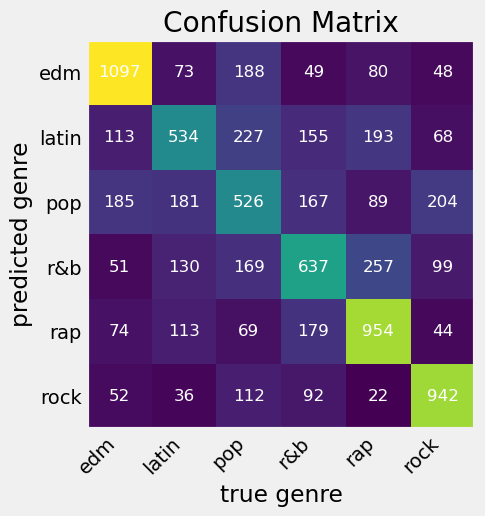

In [65]:
# Confusion matrix

mat = confusion_matrix(test_genres, predictions)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Similar to the previous models, the genres that are predicted most accurately remain EDM, rap, and rock, while the genres that are predicted least accurately continue to be Latin, pop, and R&B.

Finally, we plot again the feature importance for the CatBoost model.

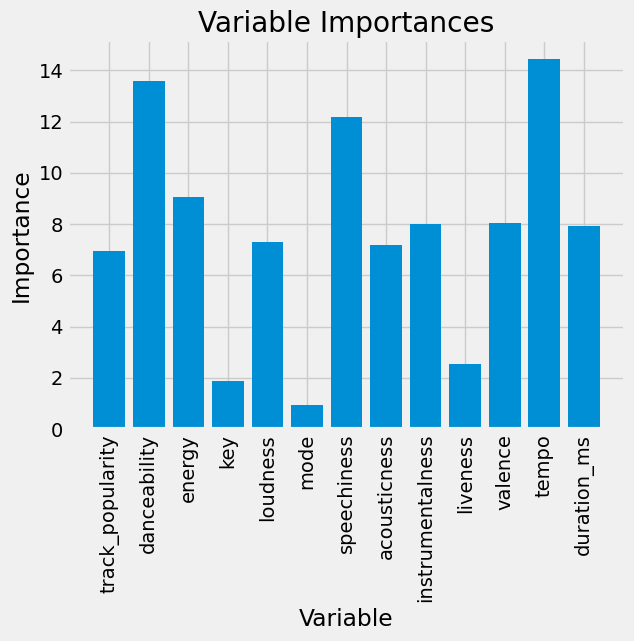

In [67]:
# Feature importances
plt.style.use('fivethirtyeight')

importances = list(model.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

We observe a change compared to the graphs from the previous two models. Indeed, it seems that the CatBoost model relies less on the "liveness" variable than the others. However, we still see similarities, such as the fact that the "key" and "mode" variables have little impact on the genre prediction.

Thus, our CatBoost model allows us to predict a music genre with an accuracy of 57%, which is quite satisfactory.

# Conclusion

With 56% accuracy, it is possible to predict a music genre based on a few audio analysis features!

We tested three models: Random Forest, XGBoost, and CatBoost, all of which gave similar and fairly satisfactory results. One area for improvement would be better prediction of pop and R&B genres. However, the main challenge of our project seems to be that genre assignment for music is inherently subjective, which is reflected in the common characteristics of genres like pop and R&B.